<a href="https://colab.research.google.com/github/jaewonlee16/Linear-Algebra/blob/master/hw05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Algebra for Electrical Systems HW 5
### <i> Least-squares polynomial fitting -- DUE 12/15

#####  - Professor Young Min Kim
#####  - TAs: Junho Lee, Hojun Jang
#####  - TA email: j12040208@snu.ac.kr
*** 

- Please fill out all `Problem #K. fill out here.` annotated parts.
- You should **NOT** use methods under `np.linalg` API. Please use generic `numpy` methods.

### <b> Problem 1 - Constructing a simple least-squares solver.
##### We follow the pseudo code in the pp. 232 of our textbook, to solve least squares via QR factorization.
##### Please read the comments carefully and fill in the TODO marks.

First, let's prepare some ingredients we have implemented in HW3.

In [82]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np

In [83]:
def norm(v):
    """
        Compute the 2-norm of given vector.
        Input:
            a batch of vector of shape [N, D] 
        Return:
            a batch of computed 2-norm of shape [N, D]
    """
    # Assume we use Frobenious norm (Euclidean norm)
    return np.sqrt(np.sum(v**2, axis=-1))


def gram_schmidt(a):
    """
    in: a - length k list of n-dim np.arrays.
    out: q - length k list of n-dim orthonormal np.arrays. 
    """
    q = []
    # orthogonalization
    for i in range(len(a)): # for i = 1, ..., k
        q_tilde = a[i]
        for j in range(len(q)): # for each dimension of q_tilde
            # recursively add dot(q)
            q_tilde = q_tilde - (np.dot(q[j], a[i]))*q[j]
        # Test for linear dependence. If \tilde{q}_i = 0.
        if np.sqrt(sum(q_tilde**2)) <= 1e-10:
            print('Vectors are linearly dependent.')
            print('GS algorithm terminates at iteration ', i+1)
            return q
        #Normalization
        else:
            q_tilde = q_tilde / norm(q_tilde)
            q.append(q_tilde)
    return q


def QR_factorization(A):
    """
    in: numpy array whose k columns are linearly independent.
    """
    # we feed gram_schmidt() A.T since it orthonormalizes row vectors of the input array. 
    # Thus, we get transposed array whose rows are orthonormal. 
    Q_transpose = np.array(gram_schmidt(A.T))
    R = Q_transpose @ A # since Q^T = Q^-1
    Q = Q_transpose.T
    return Q, R



# define the back-substitution function.
# please refer to pp.207 of our textbook.
def back_subst(R, b_tilde):
    n = R.shape[0]
    x = np.zeros(n)
    for i in reversed(range(n)): # iterate in reversed order: n, n-1, ..., 1.
        x[i] = b_tilde[i]
        for j in range(i+1, n):
            x[i] = x[i] - R[i,j] * x[j]
        x[i] = x[i]/R[i,i]
    return x


# define a solver the uses back_substituion.
def solve_via_backsub(A, b):
    # first to QR factorization
    Q, R = QR_factorization(A)

    # let b_tilde as Q^T b
    b_tilde = Q.T @ b

    # solve Rx=Q^Tb to get x.
    x = back_subst(R, b_tilde)
    return x

<!-- If we choose $\mathbf{\tilde{q}}_1= \mathbf{a}_1$, then the orthogonal component of projection of $\mathbf{a}_2$ onto $\mathbf{\tilde{q}}_1$ is $\mathbf{\tilde{q}}_2$.


Define the projecttion of vector $\mathbf{a}_2$ on the vector $\mathbf{\tilde{q}}_1$ as $\text{Proj}_{\mathbf{\tilde{q}}_1}\mathbf{a}_2 = \alpha \mathbf{a}_1$, 

 then $(\mathbf{a}_2 - \alpha \mathbf{a}_1)\cdot \mathbf{a}_1 = 0$, rearange for $\alpha$

$$
\alpha = \frac{\mathbf{a}_2^T\mathbf{a}_1}{\mathbf{a}_1^T\mathbf{a}_1}
$$

According to definition above

$$
\text{Proj}_{\mathbf{\tilde{q}}_1}\mathbf{a}_2 = \alpha \mathbf{a}_1 = \frac{\mathbf{a}_2^T\mathbf{a}_1}{\mathbf{a}_1^T\mathbf{a}_1}\mathbf{a}_1
$$

The orthogonal component, $\mathbf{\tilde{q}}_2$ is 

$$
\mathbf{a}_2- \text{Proj}_{\mathbf{\tilde{q}}_1}\mathbf{a}_2 =\mathbf{a}_2 - \frac{\mathbf{a}_2^T\mathbf{a}_1}{\mathbf{a}_1^T\mathbf{a}_1}\mathbf{a}_1
$$ -->

##### First solve toy example with numpy's innate methods. 

In [84]:
# define a matrix having linearly independent columns.
A = np.array([[3, 0], [-1, 1], [0, 3]])
b = np.array([1, 0, -1])

In Eq.(12.5) and Eq.(12.6)of our textbook, we find that

$\mathbf{\hat{x}}=(A^{\top}A)^{-1}A^{\top}\mathbf{b}=A^{\dagger}\mathbf{b}$

yields the solution for least squares problem.


In [85]:
# solve using the second term. can use np.linalg.inv for this line
sol1 = np.linalg.inv(A.T @ A) @ A.T @ b 

print(sol1)

# solve using the pinv solver of numpy. can use np.linalg.pinv for this line
sol2 = np.linalg.pinv(A) @ b 
print(sol2)

x_hat = sol2
# check of Eq.(12.4) holds.
np.allclose(A.T @ A @ x_hat, A.T @ b)

[ 0.27272727 -0.27272727]
[ 0.27272727 -0.27272727]


True

##### Now we solve the approximate solution of least squares problem via QR factorization, referring to Algorithm 12.1.

In [86]:
A = np.random.normal(size = (100, 20))
b = np.random.normal(size = 100)

# solve via our custom solver.
x1 = solve_via_backsub(A, b)

x2 = np.linalg.inv(A.T @ A) @ (A.T @ b)
x3 = np.linalg.pinv(A) @ b

print(x1)
print(np.allclose(x1, x2))
print(np.allclose(x1, x3))


[ 0.13297574 -0.11327674 -0.04699581  0.08428185  0.05184118 -0.03785396
 -0.23098697 -0.04747088  0.09052757 -0.00424866 -0.04904034  0.06889595
  0.19057105 -0.08178894  0.06091138 -0.03780935 -0.12210307  0.00993712
  0.12737147  0.02319973]
True
True


##### Now we solve the lamp illumination problem.
- There are ***n*** lamps in 3D space.
- We have to brighten a flat grid surface (z = 0).
- We have to shine each grid as equal as possible.

In [99]:
# number of lamps
n = 10
# x, y positions of lamps and height above floor 
lamps = np.array([
        [4.1, 20.4, 4], [14.1, 21.3, 3.5], [22.6, 17.1, 6],
        [5.5, 12.3, 4.0], [12.2, 9.7, 4.0], [15.3, 13.8, 6],
        [21.3, 10.5, 5.5], [3.9 ,3.3, 5.0], [13.1, 4.3, 5.0],
        [20.3, 4.2, 4.5]
    ])
N = 25 # grid size
m = N * N # number of pixels
# construct m x 2 matrix with coordinates of pixel centers

# print(np.outer(np.arange(0.5, N, 1),
#                             np.ones(N)).shape)


# assume we have 25 X 25 gridmap, where (0, 0) is the coordinate of top left corner 
# and (25, 25) is the coordinate of bottom right corner.
# the center of each grid should have tho coordinate like
# [(0.5, 0.5), (1.5, 0.5), (2.5, 0.5) ... (24.5, 0.5)]
# [(0.5, 1.5), (1.5, 1.5), (2.5, 1.5)  ...(24.5, 1.5)]
#                          ...
# [(0.5, 24.5),            ...           (24.5, 24.5)]

# define [625, 2] shaped array containing pixel coordinates.

# first create equally spaced values in [0.5, 24.5], into 25 values.
spaces = np.linspace(0.5, 24.5, 25)

# now we create value mesh for each horizontal (x) and vertical (y) axis
mesh_x, mesh_y = np.meshgrid(spaces, spaces)

# create a mesh that each node containing the center coordinate and the zero
mesh = np.stack((mesh_x, mesh_y, np.zeros((N, N))), axis=-1)

# reshape for the computation convenience
mesh = mesh.reshape(-1, 3)


# The m x n matrix A maps lamp powers to pixel intensities. 
# A[i,j] is inversely proportional to the squared distance of
# lamp j to pixel i.
A = np.zeros((m, n)) # intensity matrix for m grids and n lamps.T

for i in range(m): # iterate over m grids.
    for j in range(n): # iterate over n lamps.
        # intensity ~ inverse of squared distance
        A[i, j] = norm(mesh[i] - lamps[j])**(-2)
print(A.shape)

A = (m/np.sum(A)) * A # scale elements of A

# solve least squares equation.
x = solve_via_backsub(A, np.ones(m))
print(x)

# compute rms error.
rms_ls = (sum((A @ x - 1)**2)/m)**0.5
print(rms_ls)


(625, 10)
[1.46211018 0.78797433 2.96641047 0.74358042 0.08317333 0.21263945
 0.21218408 2.05114815 0.90760315 1.47222464]
0.14039048134276055


Let's visualize the histogram for intensity for each pixel.

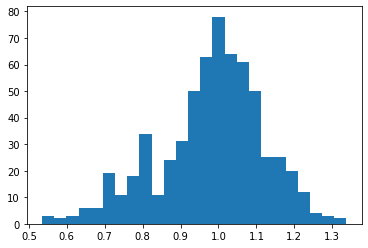

In [88]:
plt.hist(A @ x, bins = 25)
plt.show()

### <b> Problem 2. Least-squares line fitting.
##### Now we will solve line fitting problem via least-squares.

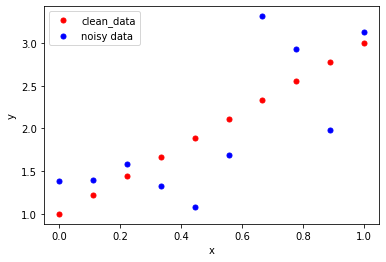

In [89]:
# define our points
x = np.linspace(0, 1, num=10)

# our line is y = 2x + 1
y_clean = 2 * x + 1
# add random noise
y_noise = y_clean + np.random.randn(len(x)) / 2.

plt.plot(x, y_clean, 'r.', markersize=10, label='clean_data')
plt.plot(x, y_noise, 'b.', markersize=10, label='noisy data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')    
plt.show()

Now we fit our `y_clean` and `y_noise` to a line `y = ax + b` via least-squares.

In [90]:
# Define matrix for solving least squares.
# We need to solve the equations written below.
# y1 = ax1 + b, y2 = ax2 + b, ..., y10 = ax10 + b
A = np.stack((np.ones(10),x), axis = -1)


# Use solve_via_backsub to get a and b values.
# The result should be in a given order [a, b].
clean_fit = np.flip(solve_via_backsub(A, y_clean))
noise_fit = np.flip(solve_via_backsub(A, y_noise))

print(clean_fit)
print(noise_fit)

[2. 1.]
[1.79619476 1.0848005 ]


Let's see if the fitting worked well.

In [91]:
clean_a = clean_fit[0]
clean_b = clean_fit[1]
noise_a = noise_fit[0]
noise_b = noise_fit[1]

y_clean_fit = clean_a * x + clean_b
y_noise_fit = noise_a * x + noise_b

# Error for fitting clean data --> should be zero
print("Error for clean data : ", np.linalg.norm(y_clean_fit - y_clean))
# Error for fitting noisy data
print("Error for noisy data : ", np.linalg.norm(y_noise_fit - y_noise))

Error for clean data :  3.8459253727671276e-16
Error for noisy data :  1.6848822141845023


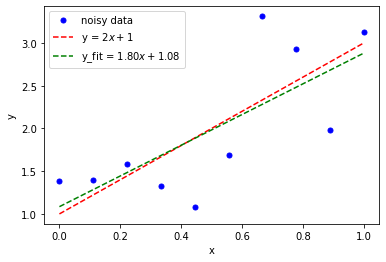

In [92]:
# Let's see the result of fitting noisy data.
plt.plot(x, y_noise, 'b.', markersize=10, label='noisy data')
plt.plot(x, y_clean, 'r--', label=r'y = $2x + 1$')
plt.plot(x, y_noise_fit, 'g--', label=r'y_fit = $%.2fx + %.2f$' % (noise_a, noise_b))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')

### <b> Problem 3. Least-squares polynomial fitting.
##### Now we will solve polynomial fitting problem via least-squares.

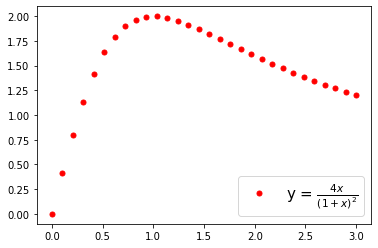

In [93]:
# define our points
x = np.linspace(0, 3, 30)

# our line is y = 4x / (1 + x^2)
y = 4 * x / (1 + x * x)

plt.plot(x, y, 'r.', markersize=10, label=r'y = $\frac{4x}{(1+x)^{2}}$')
plt.legend(loc='lower right', prop={'size': 15})

First, let's fit with line `y = ax + b`.

[0.07843853 1.38498776]


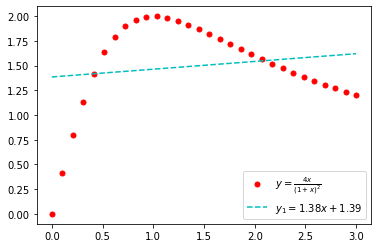

In [94]:
# Define matrix for solving least squares.
# We need to solve the equations written below.
# y1 = ax1 + b, y2 = ax2 + b, ..., y10 = ax10 + b
A = np.stack((np.ones(30),x), axis = -1)

# Use solve_via_backsub to get a and b values.
line_fit = np.flip(solve_via_backsub(A, y))

print(line_fit)

y_line_fit = line_fit[0] * x + line_fit[1]
plt.plot(x, y, 'r.', markersize=10, label=r'$y = \frac{4x}{(1+x)^{2}}$')
plt.plot(x, y_line_fit, 'c--', label=r'$y_{1} = %.2fx + %.2f$' % (y_line_fit[0], y_line_fit[1]))
plt.legend(loc='lower right')

Next, let's fit the data to a second order polynomial `y = a2 x^2 + a1 x + a0`.

[-0.54042356  1.69970922  0.60230536]


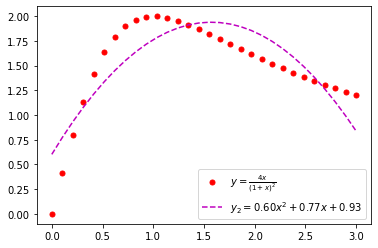

In [95]:
# Define matrix for solving least squares.
A = np.stack((np.ones(30),x, x**2), axis = -1)

# Use solve_via_backsub to get a and b values.
second_order_fit = np.flip(solve_via_backsub(A, y))

print(second_order_fit)

y_second_order_fit = second_order_fit[0] * x * x \
                     + second_order_fit[1] * x \
                     + second_order_fit[2]
plt.plot(x, y, 'r.', markersize=10, label=r'$y = \frac{4x}{(1+x)^{2}}$')
plt.plot(x, y_second_order_fit, 'm--',
         label=r'$y_{2} = %.2fx^{2} + %.2fx + %.2f$' % \
            (y_second_order_fit[0], y_second_order_fit[1], y_second_order_fit[2])
         )
plt.legend(loc='lower right')

Now let's fit the data to a third order polynomial and fourth order polynomial.

[ 0.40958818 -2.38357037  3.87422796  0.10524746]


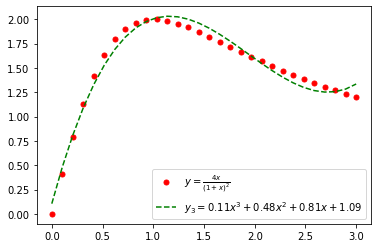

In [96]:
# Do the third order polynomial fitting.
# Define matrix for solving least squares.
A = np.stack((np.ones(30),x, x**2, x**3), axis = -1)

# Use solve_via_backsub to fit data.
third_order_fit = np.flip(solve_via_backsub(A, y))


print(third_order_fit)

y_third_order_fit = third_order_fit[0] * x * x * x \
                    + third_order_fit[1] * x * x \
                    + third_order_fit[2] * x \
                    + third_order_fit[3]

plt.plot(x, y, 'r.', markersize=10, label=r'$y = \frac{4x}{(1+x)^{2}}$')
plt.plot(x, y_third_order_fit, 'g--',
         label=r'$y_{3} = %.2fx^{3} + %.2fx^{2} + %.2fx + %.2f$' % \
            (y_third_order_fit[0], y_third_order_fit[1], y_third_order_fit[2], y_third_order_fit[3])
         )
plt.legend(loc='lower right')

[-0.15768661  1.35570782 -4.18846192  5.03136426 -0.0418086 ]


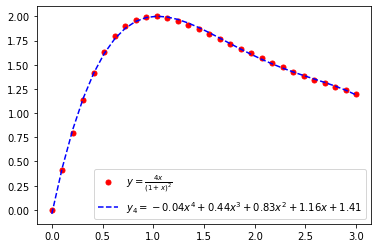

In [97]:
# Do the fourth order polynomial fitting.
# Define matrix for solving least squares.
A = np.stack((np.ones(30),x, x**2, x**3, x**4), axis = -1)

# Use solve_via_backsub to fit data.
fourth_order_fit = np.flip(solve_via_backsub(A, y))

print(fourth_order_fit)

y_fourth_order_fit = fourth_order_fit[0] * x * x * x * x \
                     + fourth_order_fit[1] * x * x * x \
                     + fourth_order_fit[2] * x * x \
                     + fourth_order_fit[3] * x \
                     + fourth_order_fit[4]

plt.plot(x, y, 'r.', markersize=10, label=r'$y = \frac{4x}{(1+x)^{2}}$')
plt.plot(x, y_fourth_order_fit, 'b--',
         label=r'$y_{4} = %.2fx^{4} + %.2fx^{3} + %.2fx^{2} + %.2fx + %.2f$' % \
            (y_fourth_order_fit[0], y_fourth_order_fit[1], y_fourth_order_fit[2], y_fourth_order_fit[3], y_fourth_order_fit[4])
         )
plt.legend(loc='lower right')

Error for first order fit :  2.4939851788857763
Error for second order fit :  1.3151556751045064
Error for third order fit :  0.3854788421942195
Error for fourth order fit :  0.0885521030363152


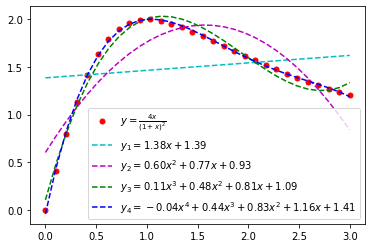

In [98]:
# Let's see all fitting results.
print("Error for first order fit : ", np.linalg.norm(y_line_fit - y))
print("Error for second order fit : ", np.linalg.norm(y_second_order_fit - y))
print("Error for third order fit : ", np.linalg.norm(y_third_order_fit - y))
print("Error for fourth order fit : ", np.linalg.norm(y_fourth_order_fit - y))

plt.plot(x, y, 'r.', markersize=10, label=r'$y = \frac{4x}{(1+x)^{2}}$')
plt.plot(x, y_line_fit, 'c--', label=r'$y_{1} = %.2fx + %.2f$' % (y_line_fit[0], y_line_fit[1]))
plt.plot(x, y_second_order_fit, 'm--',
         label=r'$y_{2} = %.2fx^{2} + %.2fx + %.2f$' % \
            (y_second_order_fit[0], y_second_order_fit[1], y_second_order_fit[2])
         )
plt.plot(x, y_third_order_fit, 'g--',
         label=r'$y_{3} = %.2fx^{3} + %.2fx^{2} + %.2fx + %.2f$' % \
            (y_third_order_fit[0], y_third_order_fit[1], y_third_order_fit[2], y_third_order_fit[3])
         )
plt.plot(x, y_fourth_order_fit, 'b--',
         label=r'$y_{4} = %.2fx^{4} + %.2fx^{3} + %.2fx^{2} + %.2fx + %.2f$' % \
            (y_fourth_order_fit[0], y_fourth_order_fit[1], y_fourth_order_fit[2], y_fourth_order_fit[3], y_fourth_order_fit[4])
         )
plt.legend(loc='lower right')